The commands below can be used to import missing dependencies inside conda

Importing all required dependencies

In [42]:
from itertools import product
from collections import defaultdict
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
import pulp
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import json
import pickle
import os
import io
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

Function to load pickle files (retro-compatible with python 2)

In [20]:
def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data

Importing Word2Vec model (https://code.google.com/archive/p/word2vec/). The next block may require a long time!

In [ ]:
wvmodel = gensim.models.KeyedVectors.load_word2vec_format(r'GoogleNews-vectors-negative300.bin', binary=True)

Testing Word2Vec model 

In [ ]:
x_test = wvmodel['man']+wvmodel['king']-wvmodel['woman']
y_test = wvmodel['queen']
z_test = wvmodel['boat']

In [ ]:
print(cosine_similarity([x_test], [y_test]))
print(cosine_similarity([x_test], [z_test]))

Useful functions 

In [ ]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [ ]:
def dot_product_lists(a,b):
    return sum([x*y for x,y in zip(a,b)])

In [ ]:
def wme_to_wmd(x,y,gamma):
    kxy = dot_product_lists(x,y)
    return -1/gamma*np.log(kxy)

Fast implementation of WMD (this is the function effectively used in the experiments)

In [ ]:
# UBER MEGA FAST WMD BY AL

from gensim.corpora.dictionary import Dictionary
def wmdistance(document1, document2, wvmodel):
        from pyemd import emd

        # Remove out-of-vocabulary words.
        len_pre_oov1 = len(document1)
        len_pre_oov2 = len(document2)
        remember_me = document2
        document2 = ['__qxvca^&3fd?#_!$' +  str(i) for i in range(len(document2))]
        diff1 = len_pre_oov1 - len(document1)
        diff2 = len_pre_oov2 - len(document2)
        if diff1 > 0 or diff2 > 0:
            logger.info('Removed %d and %d OOV words from document 1 and 2 (respectively).', diff1, diff2)

        if not document1 or not document2:
            logger.info(
                "At least one of the documents had no words that were in the vocabulary. "
                "Aborting (returning inf)."
            )
            return float('inf')

        dictionary = Dictionary(documents=[document1, document2])
        vocab_len = len(dictionary)

        if vocab_len == 1:
            # Both documents are composed by a single unique token
            return 0.0

        # Sets for faster look-up.
        docset1 = set(document1)
        docset2 = set(document2)

        wordvecs_random = {document2[i]: remember_me[i] for i in range(len(remember_me))}

        # Compute distance matrix.
        distance_matrix = np.zeros((vocab_len, vocab_len))
        for i, t1 in dictionary.items():
            if t1 not in docset1:
                continue

            for j, t2 in dictionary.items():
                if t2 not in docset2 or distance_matrix[i, j] != 0.0:
                    continue

                # Compute Euclidean distance between word vectors.
                distance_matrix[i, j] = distance_matrix[j, i] = np.sqrt(sum((wvmodel[t1] - wordvecs_random[t2])**2))

        def nbow(document):
            d = np.zeros(vocab_len)
            nbow = dictionary.doc2bow(document)  # Word frequencies.
            doc_len = len(document)
            for idx, freq in nbow:
                d[idx] = freq / float(doc_len)  # Normalized word frequencies.
            return d

        # Compute nBOW representation of documents.
        d1 = nbow(document1)
        d2 = nbow(document2)

        # Compute WMD.
        return emd(d1, d2, distance_matrix)

Implementation of Word Mover Distance (solved through LP). Next two blocks from: https://github.com/stephenhky/PyWM

In [ ]:
def tokens_to_fracdict(tokens):
    cntdict = defaultdict(lambda : 0)
    for token in tokens:
        cntdict[token] += 1
    totalcnt = sum(cntdict.values())
    return {token: float(cnt)/totalcnt for token, cnt in cntdict.items()}

In [ ]:
def word_mover_distance_probspec(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=None):
    all_tokens = list(set(first_sent_tokens+second_sent_tokens))
    wordvecs = {token: wvmodel[token] for token in all_tokens}

    first_sent_buckets = tokens_to_fracdict(first_sent_tokens)
    second_sent_buckets = tokens_to_fracdict(second_sent_tokens)

    T = pulp.LpVariable.dicts('T_matrix', list(product(all_tokens, all_tokens)), lowBound=0)

    prob = pulp.LpProblem('WMD', sense=pulp.LpMinimize)
    prob += pulp.lpSum([T[token1, token2]*euclidean(wordvecs[token1], wordvecs[token2])
                        for token1, token2 in product(all_tokens, all_tokens)])
    for token2 in second_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token1 in first_sent_buckets])==second_sent_buckets[token2]
    for token1 in first_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token2 in second_sent_buckets])==first_sent_buckets[token1]

    if lpFile!=None:
        prob.writeLP(lpFile)

    prob.solve()

    return prob

In [ ]:
def WMD_regular(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=None):
    prob = word_mover_distance_probspec(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=lpFile)
    return pulp.value(prob.objective)

We need to define WMD (through LP) also for a random document with random words

In [ ]:
def word_mover_distance_random(documents_token, random_document_vectors, wvmodel, lpFile=None):
    #We create a random association between the random_document_vectors and tokens, assuming random vectors to be all different
    first_sent_tokens = documents_token
    second_sent_tokens = ['__qxvca^&3fd?#_!$' +  str(i) for i in range(len(random_document_vectors))]
    
    all_tokens = list(set(first_sent_tokens+second_sent_tokens))
    wordvecs_document = {token: wvmodel[token] for token in first_sent_tokens}
    wordvecs_random = {second_sent_tokens[i]: random_document_vectors[i] for i in range(len(random_document_vectors))}
    #print(wordvecs_random)
    wordvecs = merge_two_dicts(wordvecs_document,wordvecs_random)

    first_sent_buckets = tokens_to_fracdict(first_sent_tokens)
    second_sent_buckets = tokens_to_fracdict(second_sent_tokens)

    T = pulp.LpVariable.dicts('T_matrix', list(product(all_tokens, all_tokens)), lowBound=0)

    prob = pulp.LpProblem('WMD', sense=pulp.LpMinimize)
    prob += pulp.lpSum([T[token1, token2]*euclidean(wordvecs[token1], wordvecs[token2])
                        for token1, token2 in product(all_tokens, all_tokens)])
    for token2 in second_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token1 in first_sent_buckets])==second_sent_buckets[token2]
    for token1 in first_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token2 in second_sent_buckets])==first_sent_buckets[token1]

    if lpFile!=None:
        prob.writeLP(lpFile)

    prob.solve()

    return prob

In [ ]:
def WMD_random(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=None):
    prob = word_mover_distance_random(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=lpFile)
    return pulp.value(prob.objective)

Test of WMD functions

In [ ]:
print(WMD_regular(['hi','bye'],['see','you'],wvmodel))
print(WMD_random(['hi','bye'],[wvmodel['see'],wvmodel['you']],wvmodel))
print(wmdistance(['hi','bye'],wvmodel['see','you'],wvmodel))

Implementation of the WME 

In [ ]:
def WME_phi(x,w,gamma,wvmodel):
    return np.exp( -gamma*wmdistance(x,w,wvmodel))

In [ ]:
def calculate_WME(documents, D_max, R, wvmodel, gamma):
    # It must returns a list of text embeddings, i-th element being the embedding of the i-th document
    
    #Phase 1: Compute v_max and v_min
    v_values = [+9999,-9999] # [v_min,v_max]
    for doc in documents:
        for token in doc:
            for x in wvmodel[token]:
                v_values[0] = min(v_values[0],x)
                v_values[1] = max(v_values[1],x)
            
    print("[v_min, v_max] = "  + str(v_values))
    Z = []
    for j in range(R):
        print("R: " + str(j+1)+"/"+str(R))
        D = 1 + np.random.randint(D_max)
        random_doc = []
        for l in range(D):
            word = np.random.uniform(v_values[0],v_values[1],size=300)
            word = word*1/np.sqrt(sum(x*x for x in word))
            random_doc.append(word)
        to_add = [WME_phi(doc,random_doc,gamma,wvmodel) for doc in documents]
        #print("to_add" + str(to_add))
        Z.append(to_add)
    ret_Z = (1/(np.sqrt(R))*np.array(Z).T).tolist()
    return ret_Z
        
        
    

Load the bbcsport_dataset (it can also be used to load other datasets we created)

In [ ]:
f = open('bbcsport_dataset.pckl','rb')
obj = pickle.load(f)
f.close()
name_dataset = obj[0]
train_R_X = obj[1]
train_R_Y = obj[2]

In [ ]:
sys.path.append('./liblinear-2.21/python/')
from liblinearutil import *

Map string labels into integers

In [ ]:
jj = 0
to_number = {}
for x in set(train_R_Y):
    to_number[x] = jj
    jj = jj + 1
int_train_R_Y = [to_number[x] for x in train_R_Y]

Cross-validation. You can set the R_values, D_values and gamma_values to test. For the classification, we use the the LIBLINEAR library imported above. The results of the experiments and the output embeddings are stored - for each value of R and gamma - in pickle files.

See the code for the structure of the pickle files and their names.

In [ ]:
CV = 10
R_values = [ 8, 16, 32, 64 , 128, 256 ]
D_values = [ 6 ]
gamma_values = [ 0.1 , 1, 10 ]
N = len(train_R_X)

for R_val in R_values:
    for D_val in D_values:
        for gamma_val in gamma_values: 
            print("Using R = " + str(R_val) + ", D = " + str(D_val) + ", gamma = " + str(gamma_val))
            embedding_points = calculate_WME(train_R_X,D_val,R_val,wvmodel,gamma_val)
            best_accuracy = -1
            best_lambda = 'boh'
            best_std = 0
            lamda_inverse = ['1e2', '3e2', '5e2', '8e2', '1e3', '3e3', '5e3', '8e3', '1e4', '3e4', '5e4', '8e4', '1e5' ,'3e5' ,'8e5' ,'1e6', '3e6', '7e6' ,'1e7' ,'5e7' ,'3e8' ,'1e9']
            for lambda_val in lamda_inverse:
                accuracy_vector = []
                kf = KFold(n_splits=10)
                kf.get_n_splits(embedding_points)
                for train_index, test_index in kf.split(embedding_points):
                    X_train = np.array(embedding_points)[train_index]
                    X_test = np.array(embedding_points)[test_index]
                    
                    Y_train = np.array(int_train_R_Y)[train_index]
                    Y_test = np.array(int_train_R_Y)[test_index]
                    
                    prob = problem(Y_train,X_train)
                    param = parameter('-s 2 -e 0.0001 -q -c ' + lambda_val)
                    m = train(prob,param)
                    p_label, p_acc, p= predict(Y_test, X_test, m)
                    ACC, MSE, SCC = evaluations(Y_test, p_label)
                    accuracy_vector.append(ACC)
                avg_ACC = np.mean(accuracy_vector)
                std_ACC = np.std(accuracy_vector)
                if(avg_ACC > best_accuracy):
                    
                    best_accuracy = avg_ACC
                    best_lambda = lambda_val
                    best_std = std_ACC
            
            print("R = " + str(R_val) + " D = " + str(D_val) + " gamma = " + str(gamma_val) + " accuracy = " + str(best_accuracy))
            #We need to save datas here
            f = open('newsgroup_WME-R'+str(R_val)+"-D"+str(D_val)+"-gamma"+str(gamma_val)+ '.pckl','wb')
            obj = [train_R_X,D_val,R_val,gamma_val,embedding_points,best_accuracy, best_std,best_lambda]
            pickle.dump(obj, f) 
            f.close()

Import the results of the experiments on bbcsport ran above from pickle files

In [25]:
file_name = "^bbcsport_WME*"
files = [f for f in os.listdir('.') if os.path.isfile(f)]
objs = []
i = 0
for f in files:
    if(re.search(file_name, f)):
        obj = load_pickle(f)
        o.close()
        objs[f] = obj

Useful function to extract the results of a run from R,D and gamma

In [37]:
def extract_stats(Rx,Dx,gammax):
    for keys in objs:
        if( (objs[keys][1] == Dx) and (objs[keys][2] == Rx) and objs[keys][3] == gammax):
            return [objs[keys][5],objs[keys][6]]

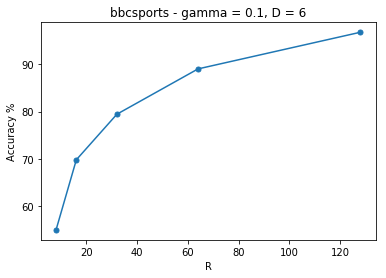

In [67]:
gamma = 0.1
D = 6
Rs = [8,16,32,64,128]
accs = []
for R in Rs:
    accuracy, std = extract_stats(R,D,gamma)
    accs.append(accuracy)

plt.figure(6)
plt.plot(Rs, accs, marker='o', markersize=5)
plt.xlabel('R')
plt.ylabel('Accuracy %')
plt.title('bbcsports - gamma = 0.1, D = 6')
plt.show()

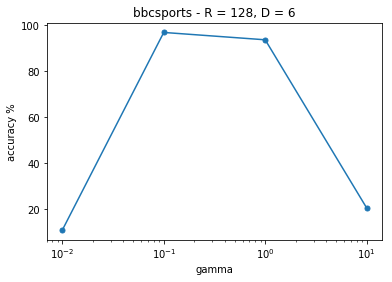

In [69]:
R = 128
gammas = [0.01, 0.1, 1, 10]
D = 6
accs = []
for gamma in gammas:
    accuracy, std = extract_stats(R,D,gamma)
    accs.append(accuracy)
    
plt.figure(6)
plt.plot(gammas, accs, marker='o', markersize=5)
plt.xscale('log')
plt.xlabel('gamma')
plt.ylabel('accuracy %')
plt.title('bbcsports - R = 128, D = 6')
plt.show() 


In [70]:
from IPython.display import HTML, display

R = 512
D = 6
gamma = 0.1

accuracy, std = extract_stats(R,D,gamma)
data = [['R=512, D=6, gamma=0.1','Accuracy','std'],
        ['Dataset: bbcsport',round(accuracy,2),round(std,2)]
        ]

display(HTML(
   '<table><tr style="height:50px; ">{}</tr></table>'.format(
       '</tr><tr style="height:50px">'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

"R=512, D=6, gamma=0.1",Accuracy,std
Dataset: bbcsport,97.6,1.87
